# Разработка скоринговой модели для максимизации прибыли
___

## Введение

Необходимо построить скоринговую модель, которая позволит максимизировать совокупную экономическую прибыль (в процентах от суммы выдачи). Скоринговая модель получает на вход значения факторов, на выходе выдает ответ, нужно ли выдавать данный заем.

Значение экономической прибыли считается следующим образом:

- Loss = Unpaid * (EL, expected loss)  
- InvestorProfit = Earned — Loss  
- Profit = InvestorProfit + Commission  
- Profit% = Profit / LoanIssued  

Задача модели состоит в том, чтобы выдавать на основе факторов займы таким образом, чтобы % экономической прибыли был максимальным.

**В качестве ответа необходимо:**
- написать скрипт, решающий данную задачу
- подробно описать ход решения
- предложить интерпретацию решения — какие именно факторы нужно изменить и почему

## *Комментарий*

Я не ставил перед собой цель решить задачу целиком и полностью, однако постарался показать свои навыки и составить хороший и законченный секелет с финальным результатом для дальнейшей работы над этим проектом. В некоторых ячейках кода используются избыточные инструменты(например, <code>pipeline</code>, исключительно с целью демонстрации его владением)

## Импорт, функции, константы

In [ ]:
!pip install catboost

In [ ]:
#import
import pandas as pd
from pandas.api.types import is_int64_dtype
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import joblib
from sklearn.model_selection import (
    train_test_split,
    cross_val_score
)
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    roc_curve,
    ConfusionMatrixDisplay
)
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
#matplotlib style
plt.style.use('seaborn-darkgrid')
#numpy formatting
np.set_printoptions(precision=3)

<ipython-input-3-434605df6a2d>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [ ]:
#constants
URL = 'https://docs.google.com/spreadsheets/d/1xjO15r02qNXPjpTuDOXfLxcBBTQ3IQJbza6CEIrsApk/export?gid=1135983843&format=csv'
SEED = 21

In [ ]:
'''
функция создает копию исходного датафрейма и очищает столбцы object от лишних
символов, а также приводит данные к нормальному кодированию unicode.
'''
def df_cleaning(dataframe):
  data = dataframe.copy()
  #unicode normalization
  data = data.apply(
      lambda x: x.str.normalize('NFKD') if x.dtype == 'object' else x
    )
  #cleaning
  data = data.apply(
    lambda x: x.str.replace('\W', '', regex = True) if x.dtype == 'object' else x
    )

  return data


In [ ]:
'''
Формулы для вычисления показателей:
loss = unpaid * EL
investor_profit = earned - loss
profit = investor_profit + comission
profit_percent = profit / loan_issued
Все формулы записаны с учетом приведения регистра к змеиному по аналогии с
исходными данными
'''
def profit(dataframe):
  data = dataframe.copy()
  loss = data['unpaid']*data['EL']/100
  investor_profit = data['earned'] - loss
  profit = investor_profit + data['comission']*data['loan_issued']/100
  data['profit'] = profit * 100 / data['loan_issued']
  data['profit'] =data['profit'].astype('float64')
  return data


In [ ]:
'''
функция приводит типы object в нужные согласно данных исходной таблицы
'''
def types_correction(dataframe):
  data = dataframe.copy()
  data = data.rename(columns = {'Loan issued':'loan_issued',
                         "Comission, %" : 'comission',
                         'Earned interest' : 'earned',
                         'Unpaid,  full amount': 'unpaid',
                                'Рейтинг':'rating'}, errors = 'ignore')
  int_cols = [col for col in data.columns if is_int64_dtype(data[col].dtype)]
  int_cols.remove('rating')
  data[int_cols] = data[int_cols].astype('object')
  data['loan_issued'] = data['loan_issued'].astype('int32')
  data['comission'] = data['comission'].astype('float64')/100
  data['earned'] = data['earned'].astype('int32')
  data['unpaid'] = data['unpaid'].astype('int32')
  data['EL'] = data['EL'].astype('float64')/100
  return data

In [ ]:
'''
функция для изображения боксплота и плотности распределения
'''
def hist_kde_plot(data,title,bins=20,x = None, xtitle = None, fontsize = 10,
                  ytitle = None, stat = 'density',color = None,
                  kde_color = 'crimson', figsize = (8,4)
                  ):
  f, (ax_box, ax_hist) = plt.subplots(2, sharex=True,
                                      figsize = figsize,
                                      gridspec_kw={"height_ratios": (.15, .85)})
  sns.boxplot(data = data,
              x = x,
              ax=ax_box,
              color = color,
              linewidth = 1)
  sns.histplot(data = data,
               x = x,
               bins = bins,
               stat = stat,
               ax =ax_hist,
               color = color,
               edgecolor = 'black',
               linewidth = 1)
  sns.kdeplot(data=data, x=x, color=kde_color, ax=ax_hist,linewidth=1)
  ax_box.set(xlabel='')
  f.suptitle(title, fontsize = round(fontsize*1.35))
  ax_hist.set_xlabel(xtitle, fontsize = fontsize)
  ax_hist.set_ylabel(ytitle, fontsize = fontsize);

In [ ]:
'''
функция для изображения плотности распределения
'''
def hist_plot(data,title,bins=20,x = None, xtitle = None, fontsize = 10,
                  ytitle = None, stat = 'density',color = None,
                  kde_color = 'crimson', figsize = (8,4), ax = None
                  ):

  sns.histplot(data = data,
               x = x,
               bins = bins,
               stat = stat,
               ax = ax,
               color = color,
               edgecolor = 'black',
               linewidth = 1)
  sns.kdeplot(data=data, x=x, color=kde_color, ax=ax,linewidth=1)
  plt.title(title, fontsize = round(fontsize*1.35))
  plt.xlabel(xtitle, fontsize = fontsize)
  plt.ylabel(ytitle, fontsize = fontsize);

In [ ]:
'''
функция для изображения графика количества пропусков
'''
def nans_plot(dataframe, title = None, figsize = (8,4)):
  data = dataframe.copy()
  (
      data.isna().sum()[data.isna().sum() != 0]
    .sort_values(ascending = True)
    .apply(lambda x: x*100/data.shape[0])
    .plot.barh(
        figsize = figsize,
        fontsize = 14,
        color = 'salmon',
        edgecolor = 'black'
    )
  )
  plt.title(title + '\n', fontsize = 18)
  plt.xlabel('Процент пропусков, %',fontsize = 16);


In [ ]:
'''
функция для изображения ROC-AUC
'''
def roc_auc_plot (features_valid, target_valid, model, x, y):
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
    plt.figure(figsize=(x,y))
    # построение графика
    plt.plot(fpr, tpr)
    # вводим ROC кривую случайной модели со значением 0.5
    plt.plot([0, 1], [0, 1], linestyle='--')
    #границы графиков
    plt.xlim(0,1)
    plt.ylim(0,1)
    #подписи осей
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #заголовок
    plt.title('ROC-кривая', fontsize = 12)
    plt.show()

## Подготовка и очистка данных

In [ ]:
#read raw data
raw_data = pd.read_csv(URL, header = 1)

In [ ]:
#check the data
raw_data.head()

,Loan issued,Рейтинг,"Comission, %",Earned interest,"Unpaid, full amount",EL,Unnamed: 6,учредителю подсказывают / на ВИ другой человек,"На ВИ присутствует ""сотрудник"", в тч за кадром, который отвечает на вопросы","""Сотрудник"" отвечает на вопросы. ГД/учредитель молчит или отвечает редко.",...,"Не знает наценку (рентабельность, прибыль)","Не знает кредиторов ), в тч объем обязательств",Нерелевантный опыт работы,Нелогичный выбор сферы бизнеса,За ответом на вопросы 10-14 просит обратиться к сотруднику,Данные предоставленные заемщиком разнятся с действительностью > 50%,"Есть ""партнер"", который официально не оформлен","Не потребовалось денег для начала бизнеса, тк были договоренности с поставщиками","Офис находится в здании партнера/друга/родственника, аренду не платит.",Заемщик от партнера и был подготовлен к ВИ
0,3 170 000 ₽,7,"5,30%",211 051 ₽,862 850 ₽,"1,50%",NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,500 000 ₽,17,"6,50%",39 518 ₽,289 518 ₽,"10,00%",NaN,0,0,0,...,0,0,1,1,0,0,0,0,0,0
2,11 600 897 ₽,9,"4,50%",537 680 ₽,9 567 386 ₽,"1,50%",NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5 250 000 ₽,13,"4,50%",233 022 ₽,2 858 022 ₽,"1,50%",NaN,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,3 000 000 ₽,8,"3,75%",216 485 ₽,0 ₽,"0,00%",NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532 entries, 0 to 531
Data columns (total 29 columns):
 #   Column                                                                            Non-Null Count  Dtype  
---  ------                                                                            --------------  -----  
 0   Loan issued                                                                       532 non-null    object 
 1   Рейтинг                                                                           532 non-null    int64  
 2   Comission, %                                                                      532 non-null    object 
 3   Earned interest                                                                   532 non-null    object 
 4   Unpaid,  full amount                                                              532 non-null    object 
 5   EL                                                                                532 non-null    object 
 6   Un

В сырых данных юмеется столбцы с лишними символами и некорректными типами данных, необходимо привести датафрейм в подходящий для дальнейшей работы вид.  


In [ ]:
#drop nan columns
raw_data.dropna(how = 'all', axis = 1, inplace = True)

In [ ]:
#get info from data
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532 entries, 0 to 531
Data columns (total 28 columns):
 #   Column                                                                            Non-Null Count  Dtype 
---  ------                                                                            --------------  ----- 
 0   Loan issued                                                                       532 non-null    object
 1   Рейтинг                                                                           532 non-null    int64 
 2   Comission, %                                                                      532 non-null    object
 3   Earned interest                                                                   532 non-null    object
 4   Unpaid,  full amount                                                              532 non-null    object
 5   EL                                                                                532 non-null    object
 6   учредителю

Столбцы типа <code>object</code> следует привести к типу <code>int64</code> или <code>float</code>. Столбцы типа <code>int64</code> являются категориальными признаками и для корректной работы будущей модели их следует привести к типу <code>object</code>



In [ ]:
#cleaning
print('Очищенный от лишних символов датафрейм \n' )
clean_data = df_cleaning(raw_data)
#check
display(clean_data.head(2))
#correct the types
data = types_correction(clean_data)
#check
print('Итоговый датафрейм \n' )
display(data.head())
print('Количество пропусков: \n')
display(data.isna().sum())
data.info()

Очищенный от лишних символов датафрейм 



,Loan issued,Рейтинг,"Comission, %",Earned interest,"Unpaid, full amount",EL,учредителю подсказывают / на ВИ другой человек,"На ВИ присутствует ""сотрудник"", в тч за кадром, который отвечает на вопросы","""Сотрудник"" отвечает на вопросы. ГД/учредитель молчит или отвечает редко.",В компании была смена учредителя,...,"Не знает наценку (рентабельность, прибыль)","Не знает кредиторов ), в тч объем обязательств",Нерелевантный опыт работы,Нелогичный выбор сферы бизнеса,За ответом на вопросы 10-14 просит обратиться к сотруднику,Данные предоставленные заемщиком разнятся с действительностью > 50%,"Есть ""партнер"", который официально не оформлен","Не потребовалось денег для начала бизнеса, тк были договоренности с поставщиками","Офис находится в здании партнера/друга/родственника, аренду не платит.",Заемщик от партнера и был подготовлен к ВИ
0,3170000,7,530,211051,862850,150,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,500000,17,650,39518,289518,1000,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0


Итоговый датафрейм 



,loan_issued,rating,comission,earned,unpaid,EL,учредителю подсказывают / на ВИ другой человек,"На ВИ присутствует ""сотрудник"", в тч за кадром, который отвечает на вопросы","""Сотрудник"" отвечает на вопросы. ГД/учредитель молчит или отвечает редко.",В компании была смена учредителя,...,"Не знает наценку (рентабельность, прибыль)","Не знает кредиторов ), в тч объем обязательств",Нерелевантный опыт работы,Нелогичный выбор сферы бизнеса,За ответом на вопросы 10-14 просит обратиться к сотруднику,Данные предоставленные заемщиком разнятся с действительностью > 50%,"Есть ""партнер"", который официально не оформлен","Не потребовалось денег для начала бизнеса, тк были договоренности с поставщиками","Офис находится в здании партнера/друга/родственника, аренду не платит.",Заемщик от партнера и был подготовлен к ВИ
0,3170000,7,5.30,211051,862850,1.5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,500000,17,6.50,39518,289518,10.0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
2,11600897,9,4.50,537680,9567386,1.5,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,5250000,13,4.50,233022,2858022,1.5,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,3000000,8,3.75,216485,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Количество пропусков: 



loan_issued                                                                         0
rating                                                                              0
comission                                                                           0
earned                                                                              0
unpaid                                                                              0
EL                                                                                  0
учредителю подсказывают / на ВИ другой человек                                      0
На ВИ присутствует "сотрудник", в тч за кадром, который отвечает на вопросы         0
"Сотрудник" отвечает на вопросы. ГД/учредитель молчит или отвечает редко.           0
В компании была смена учредителя                                                    0
учредитель женщина                                                                  0
Первое ЮЛ                                             

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532 entries, 0 to 531
Data columns (total 28 columns):
 #   Column                                                                            Non-Null Count  Dtype  
---  ------                                                                            --------------  -----  
 0   loan_issued                                                                       532 non-null    int32  
 1   rating                                                                            532 non-null    int64  
 2   comission                                                                         532 non-null    float64
 3   earned                                                                            532 non-null    int32  
 4   unpaid                                                                            532 non-null    int32  
 5   EL                                                                                532 non-null    float64
 6   уч

Типы данных приведены к корректным, проверены пропуски, значения очищены от ненужных символов. Добавим столбец с процентом прибыли в финальный датафрейм

In [ ]:
#add profit column
data = profit(data)

In [ ]:
#check the reesult
data.head()

,loan_issued,rating,comission,earned,unpaid,EL,учредителю подсказывают / на ВИ другой человек,"На ВИ присутствует ""сотрудник"", в тч за кадром, который отвечает на вопросы","""Сотрудник"" отвечает на вопросы. ГД/учредитель молчит или отвечает редко.",В компании была смена учредителя,...,"Не знает кредиторов ), в тч объем обязательств",Нерелевантный опыт работы,Нелогичный выбор сферы бизнеса,За ответом на вопросы 10-14 просит обратиться к сотруднику,Данные предоставленные заемщиком разнятся с действительностью > 50%,"Есть ""партнер"", который официально не оформлен","Не потребовалось денег для начала бизнеса, тк были договоренности с поставщиками","Офис находится в здании партнера/друга/родственника, аренду не платит.",Заемщик от партнера и был подготовлен к ВИ,profit
0,3170000,7,5.30,211051,862850,1.5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11.549472
1,500000,17,6.50,39518,289518,10.0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,8.613240
2,11600897,9,4.50,537680,9567386,1.5,0,0,0,1,...,0,0,0,0,0,0,0,0,0,7.897748
3,5250000,13,4.50,233022,2858022,1.5,0,0,0,0,...,0,0,1,0,0,1,0,0,0,8.121937
4,3000000,8,3.75,216485,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10.966167


## Анализ исходных данных - EDA

In [ ]:
#check the data
data.head(3)

,loan_issued,rating,comission,earned,unpaid,EL,учредителю подсказывают / на ВИ другой человек,"На ВИ присутствует ""сотрудник"", в тч за кадром, который отвечает на вопросы","""Сотрудник"" отвечает на вопросы. ГД/учредитель молчит или отвечает редко.",В компании была смена учредителя,...,"Не знает кредиторов ), в тч объем обязательств",Нерелевантный опыт работы,Нелогичный выбор сферы бизнеса,За ответом на вопросы 10-14 просит обратиться к сотруднику,Данные предоставленные заемщиком разнятся с действительностью > 50%,"Есть ""партнер"", который официально не оформлен","Не потребовалось денег для начала бизнеса, тк были договоренности с поставщиками","Офис находится в здании партнера/друга/родственника, аренду не платит.",Заемщик от партнера и был подготовлен к ВИ,profit
0,3170000,7,5.3,211051,862850,1.5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11.549472
1,500000,17,6.5,39518,289518,10.0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,8.613240
2,11600897,9,4.5,537680,9567386,1.5,0,0,0,1,...,0,0,0,0,0,0,0,0,0,7.897748


In [ ]:
#let's see main parameters of numeric data
#we will watch only first columns
data.describe()

,loan_issued,rating,comission,earned,unpaid,EL,profit
count,5.320000e+02,532.000000,532.000000,532.000000,5.320000e+02,532.000000,532.000000
mean,3.093979e+06,11.759398,5.377519,126600.654135,1.946662e+06,5.854323,6.141309
std,2.566761e+06,3.522113,1.137612,110994.454103,2.126333e+06,14.473071,11.670690
min,5.000000e+05,1.000000,2.000000,0.000000,0.000000e+00,0.000000,-110.484560
25%,1.446742e+06,9.000000,4.757500,46535.250000,5.014298e+05,1.500000,5.364334
50%,2.293214e+06,12.000000,5.510000,93616.500000,1.323598e+06,1.500000,7.942898
75%,4.000000e+06,14.000000,6.207500,188349.250000,2.598033e+06,1.500000,10.482786
max,1.894739e+07,18.000000,8.300000,740031.000000,1.837768e+07,100.000000,21.720865


In [ ]:
#corr matrix
corr = data.corr(
    method = 'pearson',
    numeric_only = True
)
corr.style.background_gradient(cmap='coolwarm')

,loan_issued,rating,comission,earned,unpaid,EL,profit
loan_issued,1.000000,-0.419515,-0.318066,0.725222,0.818240,-0.044508,-0.019670
rating,-0.419515,1.000000,0.376776,-0.286372,-0.264558,0.102532,-0.045163
comission,-0.318066,0.376776,1.000000,-0.156140,-0.151213,0.109073,0.028754
earned,0.725222,-0.286372,-0.156140,1.000000,0.374777,0.034830,0.162096
unpaid,0.818240,-0.264558,-0.151213,0.374777,1.000000,-0.046826,-0.122924
EL,-0.044508,0.102532,0.109073,0.034830,-0.046826,1.000000,-0.820964
profit,-0.019670,-0.045163,0.028754,0.162096,-0.122924,-0.820964,1.000000


Видно, что в данных имеются убыточные займы, посмотрим на их число

In [ ]:
#количество убыточных займов
print('Величина убыточных займов:')
print(round(100*data.query('profit < 0')['profit'].count()/data.shape[0],2),'%')

Величина убыточных займов:
7.33 %


Оценку степени корреляции проводим по шкале Чеддока:
- высокая корреляция наблюдается у выданного займа и колонок с заработанной суммой и тела займа
- рейтинг умеренно понижается при увеличении суммы займа и слабо увеличивается с увеличением процента комиссии  
- ожидаемые потери сильно отрицательно коррелируют с процентом прибыли


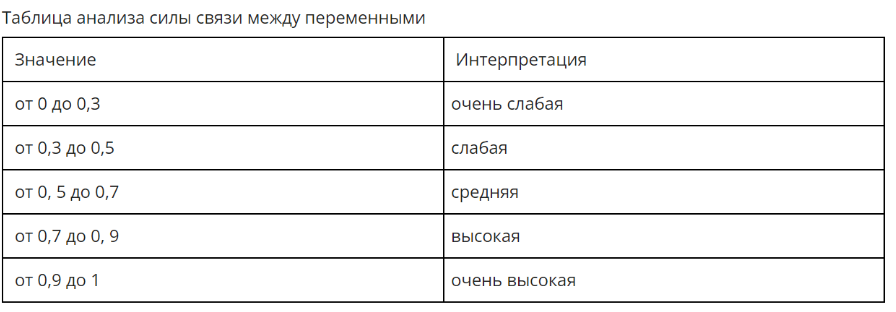

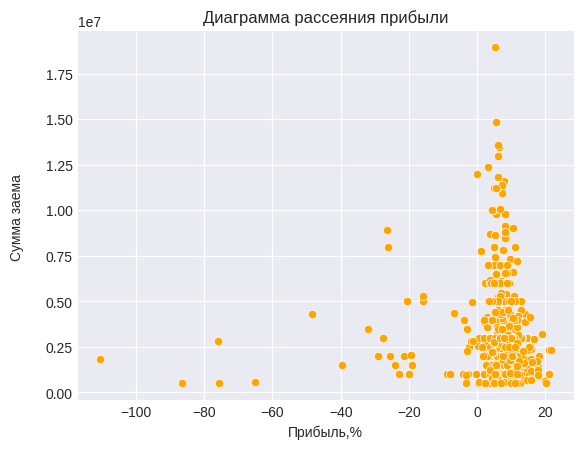

In [ ]:
#диаграмма рассеяния для прибыли
sns.scatterplot(
    data = data,
    x = 'profit',
    y ='loan_issued',
    color = 'orange'
)
plt.title('Диаграмма рассеяния прибыли', fontsize = 12)
plt.xlabel('Прибыль,%')
plt.ylabel('Сумма заема \n');

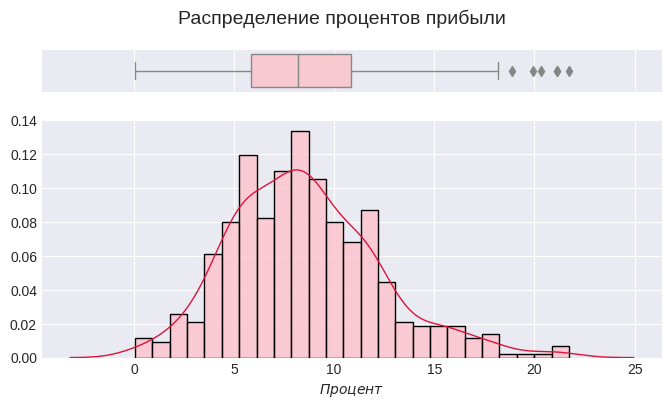

In [ ]:
#распределение прибыли с заемов
hist_kde_plot(data.query('profit > 0'), 'Распределение процентов прибыли', bins = 25,
            x = 'profit', xtitle = '$Процент$', ytitle = '',
              color = 'pink')


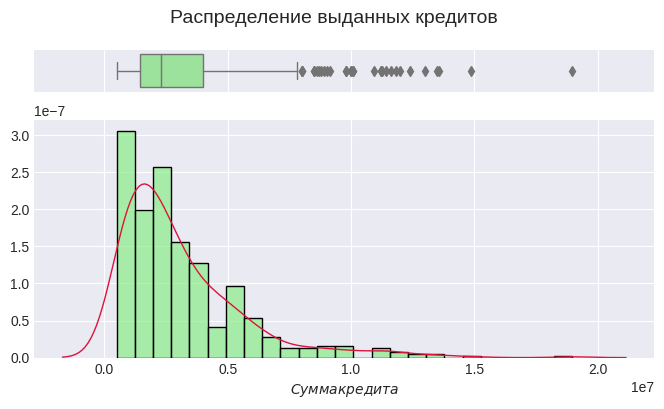

In [ ]:
#распределение выданных кредитов
hist_kde_plot(data, 'Распределение выданных кредитов', bins = 25,
            x = 'loan_issued', xtitle = '$Сумма кредита$', ytitle = '',
              color = 'lightgreen')

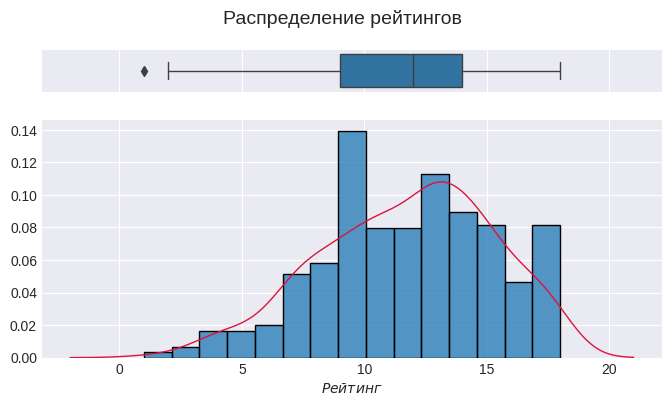

In [ ]:
#распределение рейтингов
hist_kde_plot(data, 'Распределение рейтингов', bins = 15,
            x = 'rating', xtitle = '$Рейтинг$', ytitle = '')

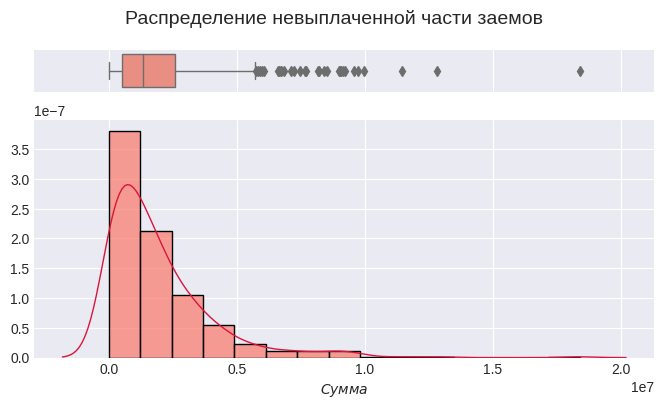

In [ ]:
#распределение unpaid части заемов
hist_kde_plot(data, 'Распределение невыплаченной части заемов', bins = 15,
            x = 'unpaid', xtitle = '$Сумма$', ytitle = '', color = 'salmon')

### Сводная таблица по заданию

In [ ]:
#скрипт для построения сводной таблицы
#заполняет NaN нулями
pivot = data.pivot_table(index = 'comission',columns = 'rating',
                         values = 'loan_issued',
                         aggfunc = 'sum', fill_value = 0,
                         margins = True
                         ).sort_values('All', axis = 1,ascending = False)
pivot = pivot.sort_values('All',ascending = False)
pivot = pivot.drop('All', axis = 1)
pivot = pivot.drop('All')

In [ ]:
#check
pivot

rating,10,13,11,7,9,12,8,14,15,4,16,6,17,5,18,3,2,1
comission,,,,,,,,,,,,,,,,,,
6.00,52766929,15510000,32001327,22990000,48959956,25005267,17790000,3850382,3672000,0,0,2927736,6500000,0,1500000,1000000,0,0
6.50,0,50173218,1436970,0,1000000,4910000,0,38446054,37591743,0,22200690,0,19530000,0,10270000,0,0,0
5.00,15770000,21000000,24718461,4190768,7500000,10870000,7500000,6620000,800000,0,7880000,3000000,1000000,12550000,1000000,0,0,0
5.50,0,24600000,5000000,0,0,5500000,0,12834671,6660000,10000000,1700000,9500000,6880000,12490000,2680000,0,4300000,1500000
4.50,6000000,12160000,7300000,0,27490897,3000000,9000000,6000000,1930000,0,1500000,13000000,500000,0,500000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6.08,0,0,0,0,0,0,0,0,855744,0,0,0,0,0,0,0,0,0
2.25,0,0,0,0,0,800000,0,0,0,0,0,0,0,0,0,0,0,0
4.82,0,0,0,0,0,0,0,0,0,0,700000,0,0,0,0,0,0,0


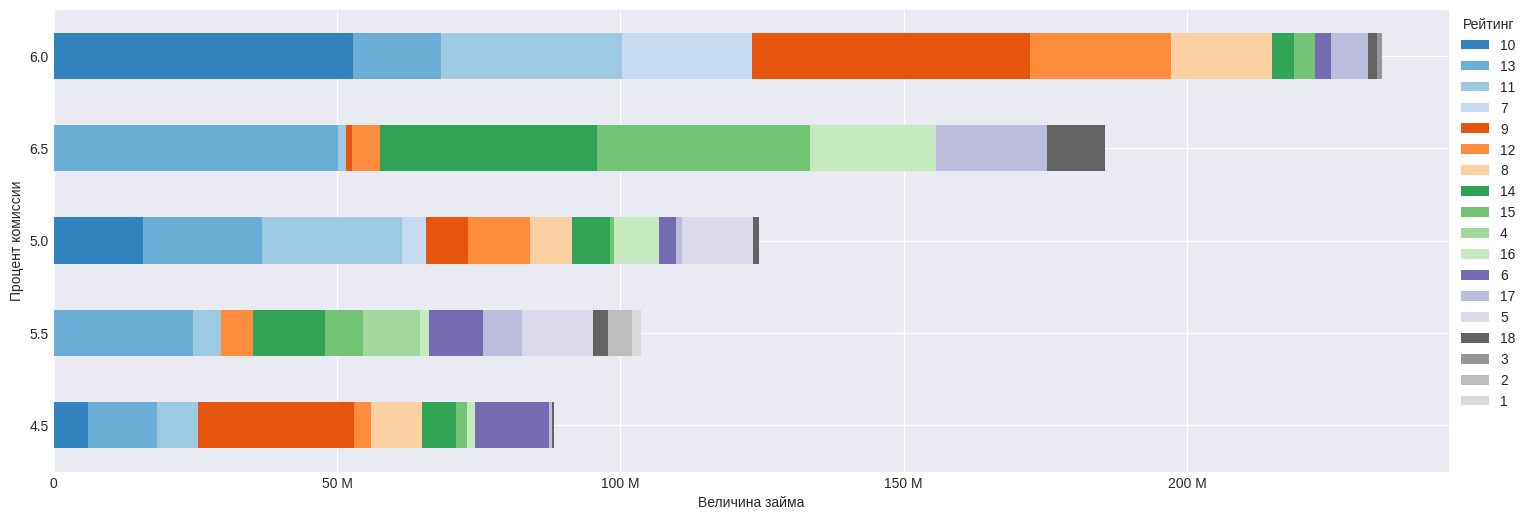

In [ ]:
#топ-5 крупных сумм займов с процентами комиссии
ax = pivot.head().plot.barh(
    figsize = (18,6),
    stacked = True,
    colormap = 'tab20c'
)
#форматирование вывода графика
ax.xaxis.set_major_formatter(ticker.EngFormatter())
ax.invert_yaxis()
ax.set(xlabel='Величина займа', ylabel='Процент комиссии')
ax.legend(title='Рейтинг', bbox_to_anchor=(1, 1.01), loc='upper left');


Из графика видно, что больше всего займов выдано с комиссией от 4 до 6 %.
У разных размеров комиссий наблюдаются разные рейтинги, но в основном наиболее значимые по величине это займы с рейтингами <code>10,13,11,7,9,12,8</code>.

### Вывод по EDA

Около 7% заемов являются убыточными, наибольшее число заемов выдано суммами до 500 тыс. руб.  
Большая часть заемов выдана под высокий процент комиссии - от 4.5 до 6.5 % с рейтингами от 9 до 15


## Построение моделей и кросс-валидация


Модели необходимо выдать оценку - выдавать заем или нет - с точки зрения маскимизации прибыли. Соотвественно, решается задача классификации заема на условно положительный - прибыльный и условно отрицательный - убыточный или маскимизирующий прибыль недостаточно

Перед началом работы необходимо определиться с пороговым значением прибыли, после которого заем считается максимизирующим приыбль.
Я выберу значение 25-ого квантиля. После этого можно будет проставить метки класса, то есть определить целевые значения для классификаторов

In [ ]:
#присваеваем метки класса
#1 - положительный
#0 - отрицательный
data['class'] = np.where(data['profit'] > 5, 1, 0)
data.head()

,loan_issued,rating,comission,earned,unpaid,EL,учредителю подсказывают / на ВИ другой человек,"На ВИ присутствует ""сотрудник"", в тч за кадром, который отвечает на вопросы","""Сотрудник"" отвечает на вопросы. ГД/учредитель молчит или отвечает редко.",В компании была смена учредителя,...,Нерелевантный опыт работы,Нелогичный выбор сферы бизнеса,За ответом на вопросы 10-14 просит обратиться к сотруднику,Данные предоставленные заемщиком разнятся с действительностью > 50%,"Есть ""партнер"", который официально не оформлен","Не потребовалось денег для начала бизнеса, тк были договоренности с поставщиками","Офис находится в здании партнера/друга/родственника, аренду не платит.",Заемщик от партнера и был подготовлен к ВИ,profit,class
0,3170000,7,5.30,211051,862850,1.5,0,0,0,0,...,0,0,0,0,0,0,0,0,11.549472,1
1,500000,17,6.50,39518,289518,10.0,0,0,0,0,...,1,1,0,0,0,0,0,0,8.613240,1
2,11600897,9,4.50,537680,9567386,1.5,0,0,0,1,...,0,0,0,0,0,0,0,0,7.897748,1
3,5250000,13,4.50,233022,2858022,1.5,0,0,0,0,...,0,1,0,0,1,0,0,0,8.121937,1
4,3000000,8,3.75,216485,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,10.966167,1


In [ ]:
#баланс классов
display(data['class'].value_counts())
balance = (data['class'].value_counts()[0]/data['class'].value_counts()[1])
print(f'Класс 0 : Класс 1 = {balance}')

1    416
0    116
Name: class, dtype: int64

Класс 0 : Класс 1 = 0.27884615384615385


In [ ]:
#словарь
dict_classes={0:1, 1:round(balance,3)}
#check
dict_classes

{0: 1, 1: 0.279}

In [ ]:
#создадим набор признаков из очищенных данных
features = data.select_dtypes('object')
target = data['class']

In [ ]:
#check
display(features.head())

,учредителю подсказывают / на ВИ другой человек,"На ВИ присутствует ""сотрудник"", в тч за кадром, который отвечает на вопросы","""Сотрудник"" отвечает на вопросы. ГД/учредитель молчит или отвечает редко.",В компании была смена учредителя,учредитель женщина,Первое ЮЛ,Выручка компании в первый год > 30 млн.,Текущее ЮЛ основано до 30 лет,КИ учредителя < 1 млн,Не знает объем выручки,...,"Не знает наценку (рентабельность, прибыль)","Не знает кредиторов ), в тч объем обязательств",Нерелевантный опыт работы,Нелогичный выбор сферы бизнеса,За ответом на вопросы 10-14 просит обратиться к сотруднику,Данные предоставленные заемщиком разнятся с действительностью > 50%,"Есть ""партнер"", который официально не оформлен","Не потребовалось денег для начала бизнеса, тк были договоренности с поставщиками","Офис находится в здании партнера/друга/родственника, аренду не платит.",Заемщик от партнера и был подготовлен к ВИ
0,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,1,0,1,0,0,...,0,0,1,1,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#разбиваем на выборки со стратификацией
features_train, features_test, target_train, target_test = \
train_test_split(features,target,test_size=0.3, random_state=SEED, stratify = data['class'])
#check
print('Размер обучающей выборки:', features_train.shape[0])
#check
print('Размер тестовой выборки:', features_test.shape[0])
#условие равенства выборок
print('Условие равенства выборок:')
features_train.shape[0] + features_test.shape[0] == data['class'].shape[0]

Размер обучающей выборки: 372
Размер тестовой выборки: 160
Условие равенства выборок:


True

### Логистическая регрессия

С точки зрения максимизации прибыли важно, чтобы модель классифицировала точно выданный заем, а также среди всех потенциально прибыль заемов находила как можно больше, т.е. нам важны и <code>Recall</code> и <code>Precision</code>.
Выберем метрику F1.
Модели будем сохранять через <code>joblib</code>

Для экономии времени я не буду заниматься доскональным подбором гиперпараметров, но изложу основные моменты и дам комментарии в итоговом выводе о том, что можно было бы добавить и\или улучшить

In [ ]:
#параметры для GS
lr_params={'model__C':[0.1,0.5,1,3,5],
           'model__solver':['lbfgs', 'liblinear']
          }

#pipeline для регрессии
lr_pipeline = Pipeline([('model',LogisticRegression(max_iter = 500,
                                                     class_weight = dict_classes,
                                                     random_state = 21,
                                                     tol = 1e-3))])

#gridsearch initialization
lr_grid = GridSearchCV(lr_pipeline, cv = 5, param_grid=lr_params,
                       scoring='f1',verbose = 3, n_jobs = -1)

In [ ]:
lr_grid.fit(features_train, target_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        LogisticRegression(class_weight={0: 1,
                                                                         1: 0.279},
                                                           max_iter=500,
                                                           random_state=21,
                                                           tol=0.001))]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 0.5, 1, 3, 5],
                         'model__solver': ['lbfgs', 'liblinear']},
             scoring='f1', verbose=3)

In [ ]:
#score
lr_grid.best_score_

0.7465833783861175

In [ ]:
#best model
joblib.dump(lr_grid.best_estimator_['model'], 'logistic.pkl')

['logistic.pkl']

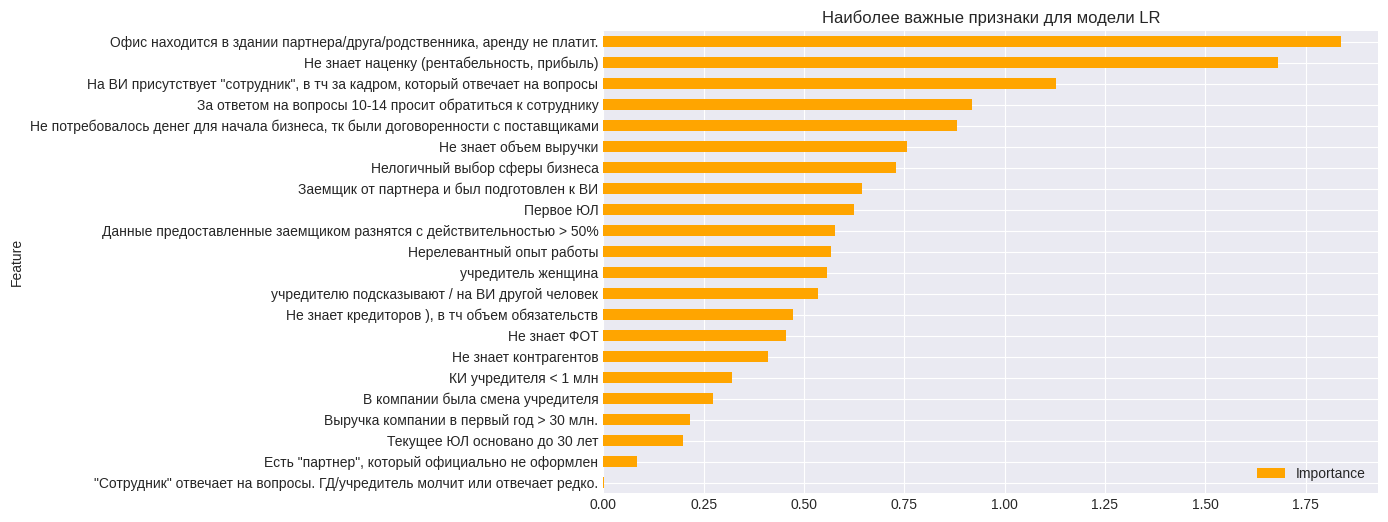

In [ ]:
#feature importance
coefficients = lr_grid.best_estimator_['model'].coef_[0]
#график
log_feature_importance = pd.DataFrame({'Feature': features.columns, 'Importance': np.abs(coefficients)})
log_feature_importance = log_feature_importance.sort_values('Importance', ascending=True)
log_feature_importance.plot(
    x='Feature',
    y='Importance',
    kind='barh',
    figsize=(10, 6),
    color = 'orange'
    )
plt.title('Наиболее важные признаки для модели LR', fontsize = 12);

### CatBoost

In [ ]:
#параметры для GS
cat_params={'model__learning_rate':[x/10 for x in range(1,5,1)],
             'model__depth': [x for x in range (2,6,1)]
            }

#pipeline для регрессии
cat_pipeline = Pipeline([('model',CatBoostClassifier(random_state = 21,
                                                    class_weights = dict_classes,
                                                    iterations = 150))])

#gridsearch initialization
cat_grid = GridSearchCV(cat_pipeline, cv = 5, param_grid=cat_params,
                       scoring='f1',verbose = 2, n_jobs = -1)

In [ ]:
%%time
#catboost fit
cat_grid.fit(features_train,target_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
0:	learn: 0.6803963	total: 48.4ms	remaining: 7.21s
1:	learn: 0.6757802	total: 51.4ms	remaining: 3.8s
2:	learn: 0.6689858	total: 53.2ms	remaining: 2.6s
3:	learn: 0.6609078	total: 55.3ms	remaining: 2.02s
4:	learn: 0.6527129	total: 57.1ms	remaining: 1.66s
5:	learn: 0.6466455	total: 59.2ms	remaining: 1.42s
6:	learn: 0.6410164	total: 61.1ms	remaining: 1.25s
7:	learn: 0.6357187	total: 62.8ms	remaining: 1.11s
8:	learn: 0.6330402	total: 64.5ms	remaining: 1.01s
9:	learn: 0.6300286	total: 66.2ms	remaining: 926ms
10:	learn: 0.6232128	total: 68ms	remaining: 859ms
11:	learn: 0.6154120	total: 72ms	remaining: 828ms
12:	learn: 0.6111616	total: 73.7ms	remaining: 777ms
13:	learn: 0.6065483	total: 82ms	remaining: 796ms
14:	learn: 0.6005431	total: 84ms	remaining: 756ms
15:	learn: 0.5969711	total: 85.6ms	remaining: 717ms
16:	learn: 0.5930787	total: 87.4ms	remaining: 684ms
17:	learn: 0.5896184	total: 89.3ms	remaining: 655ms
18:	learn: 0.5844361	to

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        <catboost.core.CatBoostClassifier object at 0x7c7af54112d0>)]),
             n_jobs=-1,
             param_grid={'model__depth': [2, 3, 4, 5],
                         'model__learning_rate': [0.1, 0.2, 0.3, 0.4]},
             scoring='f1', verbose=2)

In [ ]:
#score
cat_grid.best_score_

0.7903592976987472

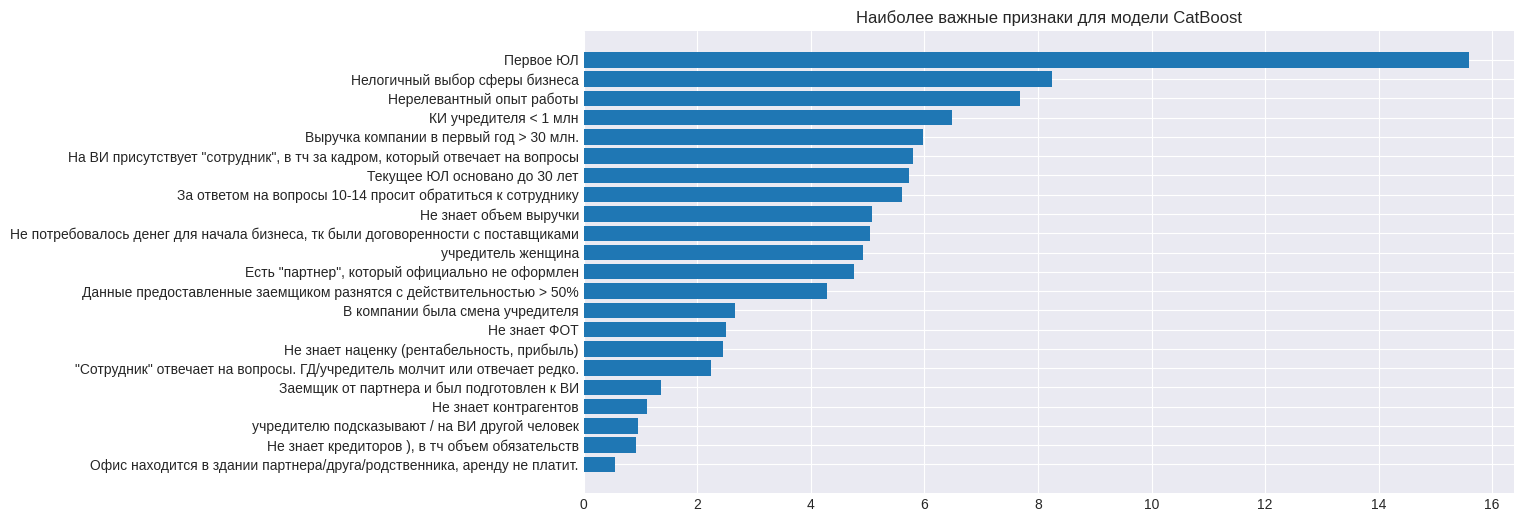

In [ ]:
#feature_importance
feature_importance = cat_grid.best_estimator_['model'].feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_train.columns)[sorted_idx])
plt.title('Наиболее важные признаки для модели CatBoost');


In [ ]:
#save model
joblib.dump(cat_grid.best_estimator_['model'],'catboost.pkl')


['catboost.pkl']

### Вывод по тюнингу параметров и кросс-валидации

По итогам кросс валидации лучше себя показала модель градиентного бустинга CatBoost. Проверим её на тестовой выборке

## Тестирование

За отправную точку возьмем дамми-классификатор, который будет предсказывать случайную величину равновероятно

In [ ]:
#dummy classifier
dummy = DummyClassifier(strategy = 'uniform', random_state = 21,
                       constant = 1)
dummy.fit(features_train, target_train)
dummy_preds = dummy.predict(features_test)
dummy_score = f1_score(dummy_preds,target_test)
print('Dummy F1 score:', dummy_score)

Dummy F1 score: 0.603960396039604


Ранее сохраненную модель выгружаем с помощью joblib

In [ ]:
#имя модели
NAME = 'catboost.pkl'
#загружаем с помощью joblib
test_model = joblib.load(NAME)

In [ ]:
#тестирование модели
test_model.fit(features_train,target_train, silent = True)
test_preds = test_model.predict(features_test)
#test_score
test_score = f1_score(test_preds,target_test)

In [ ]:
#final score
print('Test model F1 score:', test_score)

Test model F1 score: 0.7161572052401747


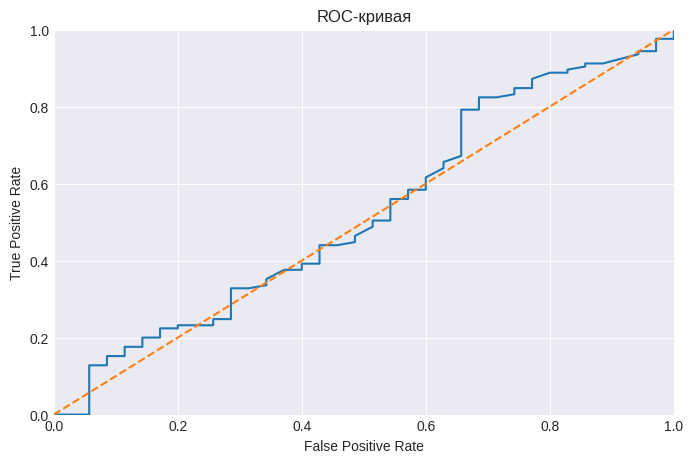

In [ ]:
#roc-auc plot
roc_auc_plot(features_test,target_test,test_model,8,5)

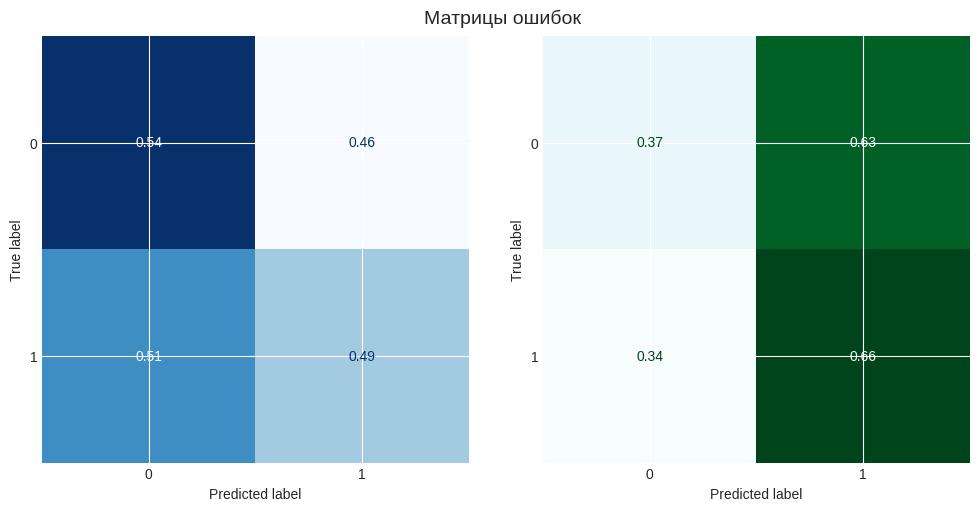

In [ ]:
#confusion matrixes
fig,axes = plt.subplots(1,2,figsize = (10,5),constrained_layout = True)
fig.suptitle('Матрицы ошибок', fontsize = 14)
ConfusionMatrixDisplay.from_estimator(dummy,features_test, target_test,
                                      ax = axes[0],cmap = 'Blues',
                                      normalize = 'true',
                                      colorbar = False)
ConfusionMatrixDisplay.from_estimator(test_model,features_test, target_test,
                                      ax = axes[1],cmap = 'BuGn',
                                      normalize = 'true',
                                      colorbar = False);

## Выводы по моделям

Из матрицы ошибок видно, что полученная модель находится в очень сыром виде. Процент правильного определения класса 1 - выдачи заема - равен 66%, при этом величина ложноположительных меток составляет 63%, что означает высокий риск выдачи убыточных займов.  
Величина ложноотрицательных меток класса составляет 34%, что также негативно сказывается на максимизации прибыли
Процент определенных убыточных займов составляет 37%.
По кривой ROC-AUC видно, что модель с трудом опережает случайную модель, что говорит о необходимости доработок.

## Выводы по задаче

В качестве рекомендаций по улучшению результата предлагаю следующее:
- возможно в формуле по определению прибыли допущена ошибка:  
 <code>profit = investor_profit + comission</code>  

 мы прибавляем к определенной сумме проценты (исходя из предоставленных данных)  

 я же использовал такой вариант, где комиссия вычисляется как процент от суммы займа:  
 <code>profit = investor_profit + comission*loan_issued</code>  
<u>следует точнее определить что является прибылью в таком случае</u>
- определиться с метрикой: какой порог прибыльности считается максимизирующим прибыль, поскольку я брал значение опираясь на распределение доходности и самостоятельно размечал данные на основании этого значения
- увеличить число элементов в выборке
- использовать другие методы по борьбе с дисбалансом классов в данных(если таковой будет иметь место)
- использовать другие модели - SVM, KNN, полносвязные нейросети, попробовать бэггинг или стакинг
- оптимизировать подбор гиперпараметров
- произвести выбор признаков исходя из их важности с точки зрения модели
- добавить дополнительные признаки на основе имеющихся
- добавить числовые признаки к категориальным
